# Time-series MWTA

## Intro
* **Date**: 12/29/2020
* **What**: Basically, I'm going to do two things in this experiment.  First I'm going to cook up a dataset where a NxN window passes over a tapestry of MNIST digits, and essentially creates a movie of the process.  Then I'm going to pass that dataset through a MWTA layer with maybe 5-10 winners.  Depending on how long that portion of the experiment takes, I might try to start cooking up the second layer, which would be the smaller, "invariant" layer.  We'll see.
* **Why**: Because time series is the only way.  I think probably the fastest way more my networks to grok invariant structures is to watch their infinitesimal progressions through time.  This is how our brain intakes data, so it's probably not a bad idea to get my networks to do this as well. 
* **Hopes**: This is mostly just a qualitative experiment, but I hope to figure out how to view movies with plt, or something similar.  Maybe OpenCV.  I'm really interested in seeing the prototypes that come out of the mwta layer as well.
* **Limitations**: This is really just qualitative, so I don't think there are any major limitations from the algo side.  Maybe I'll run into some tech difficulties, but I don't think they'll be huge.

## Code

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

<IPython.core.display.Javascript object>


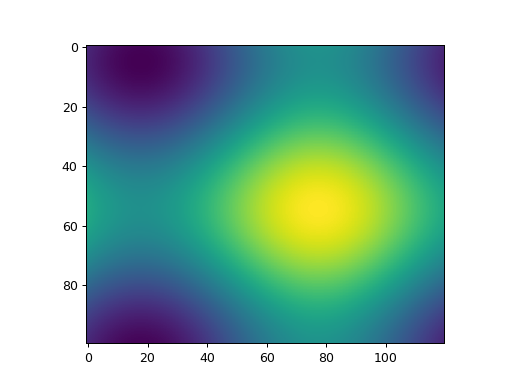

In [6]:
%matplotlib notebook
fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(100):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=500)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

Ok, dope, so that's a basic animation.  I'm going to turn it off now, but just run the above cell if you want to see the good good 2d sine go across the screen.  Ok, I'm going to make my tapestry.

In [4]:
t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 0

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

<IPython.core.display.Javascript object>


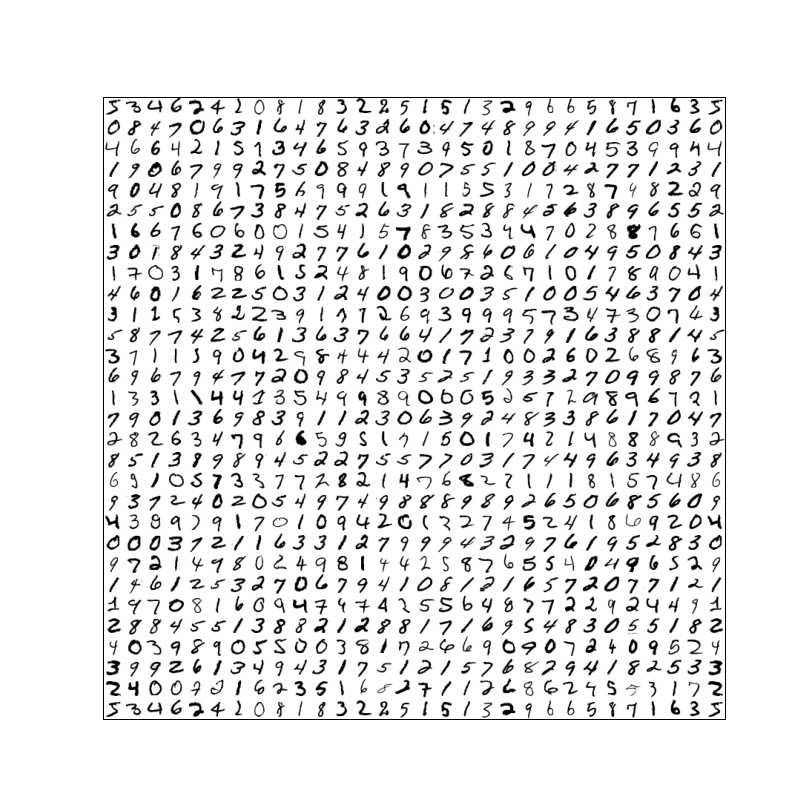

In [5]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

Cool, so there's my beautiful tapestry.  Now, let's make a movie out of it.

In [6]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])

<IPython.core.display.Javascript object>


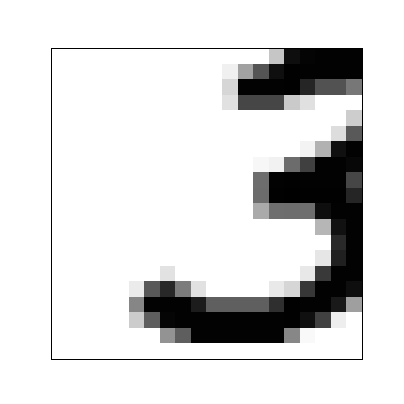

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(5, 5))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

# Analysis Dialog

Well, that is just fantastic.  It looks just oh so great.  (To run the animation, just run the cell).

Well, we both know what I need to do now.  Let's pass this bad boi through a mwta layer!

In [8]:
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)

In [9]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


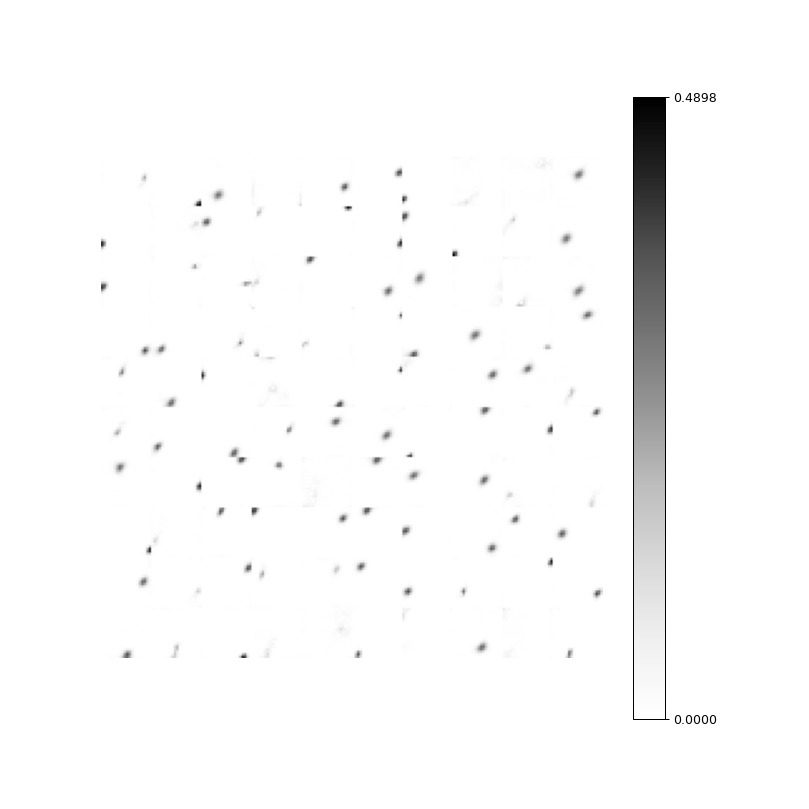

100%|█████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2979.88it/s]


In [68]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.002

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

Well, that's interesting.  I'm going to try a fewer number of winners, and see if we can get more structure.

Actually, wait.  I'm going to do some quick reconstructions.

In [73]:
def reconstruct(img_i, w):
    s_len = 20

    img = ts_data[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = np.tanh(mask * p)
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len), cmap="Greys", vmax=1)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(10, 10), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

    plt.show()

<IPython.core.display.Javascript object>


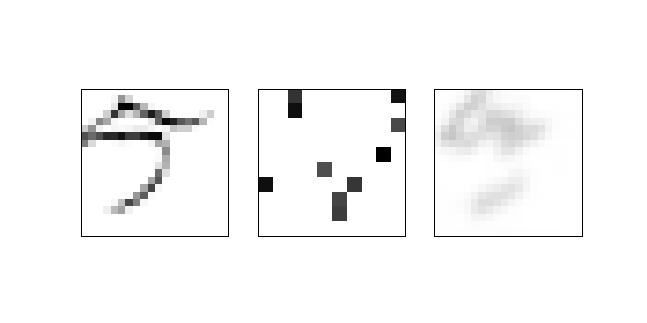

<IPython.core.display.Javascript object>


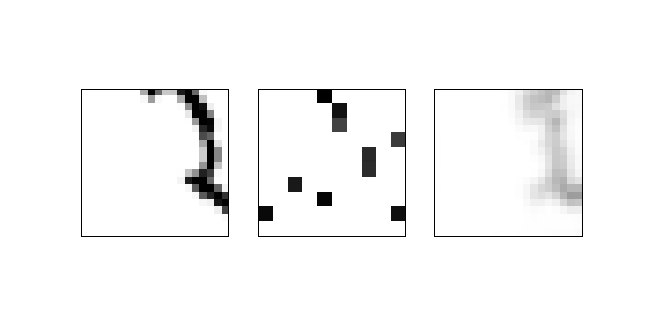

<IPython.core.display.Javascript object>


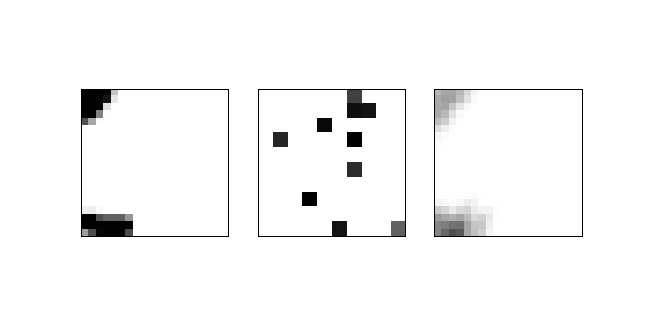

<IPython.core.display.Javascript object>


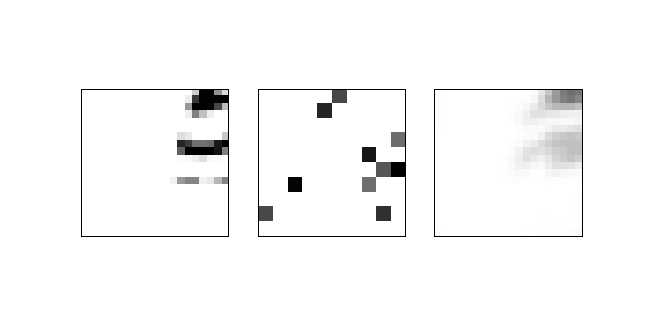

<IPython.core.display.Javascript object>


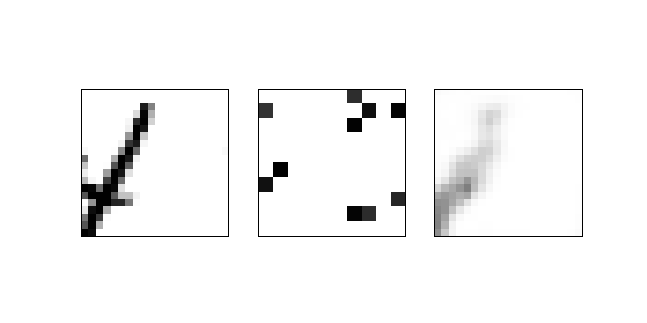

In [79]:
for _ in range(5):
    i = int(np.random.uniform(0, img_count))
    reconstruct(i, w)

Wow.  Well, that is fascinating.  Ok, now I'm going to take the winner count down and see what we can get.

<IPython.core.display.Javascript object>


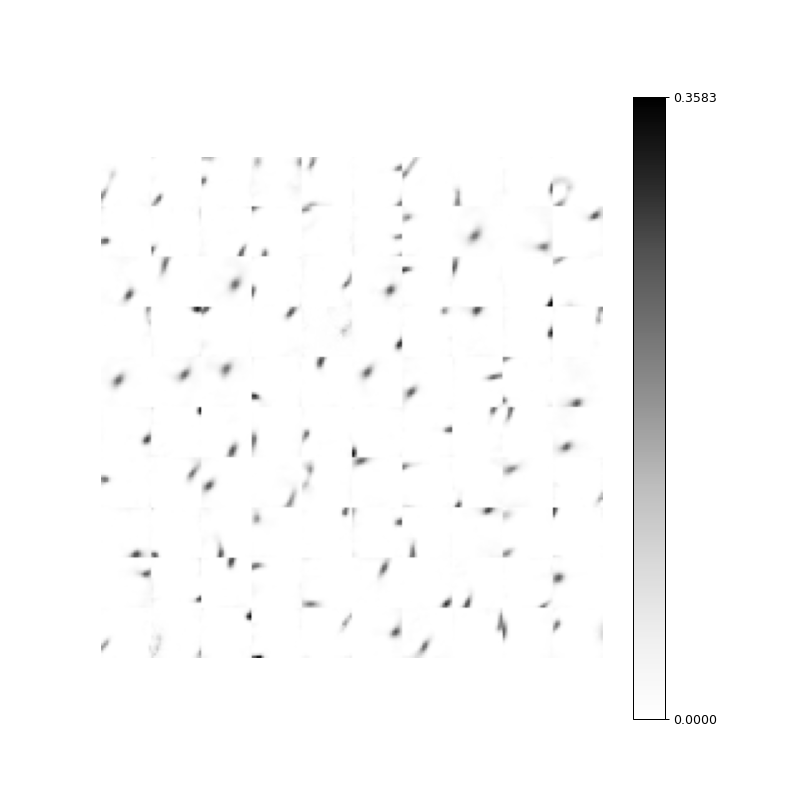

100%|█████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2931.19it/s]


In [82]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10_000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.002

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

Now, *that* is more interesting.  I bumped the number of epochs up to 20 just because the neurons weren't really settling down, even with such a small $\xi$.  They still weren't really settling after 20 epochs, but that doesn't really matter.  

Let's see some reconstructions!

<IPython.core.display.Javascript object>


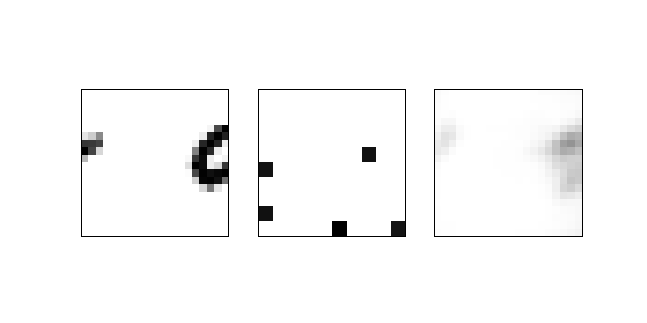

<IPython.core.display.Javascript object>


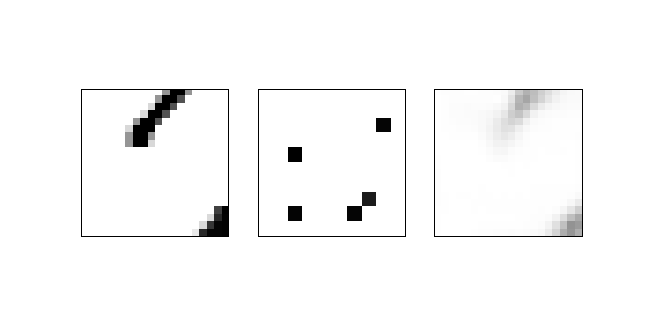

<IPython.core.display.Javascript object>


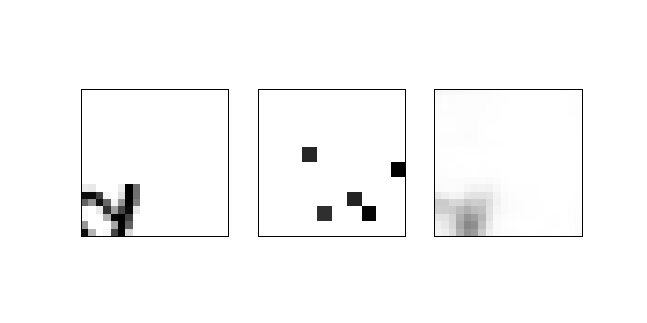

<IPython.core.display.Javascript object>


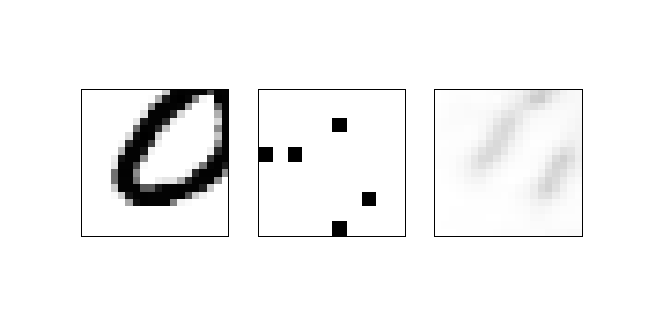

<IPython.core.display.Javascript object>


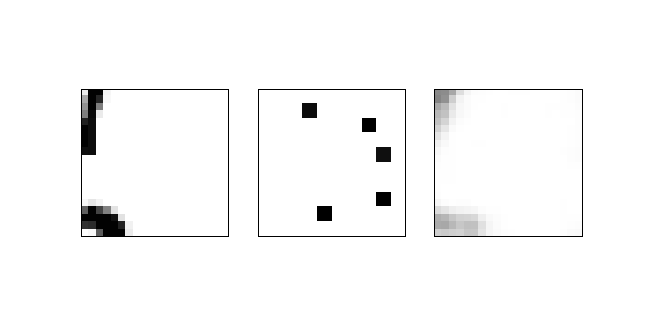

In [83]:
for _ in range(5):
    i = int(np.random.uniform(0, img_count))
    reconstruct(i, w)

Yeah, well, you can't get a whole lot better than that with so few neurons to capture the structure.  Speaking of which, let's up the neuron count.

<IPython.core.display.Javascript object>


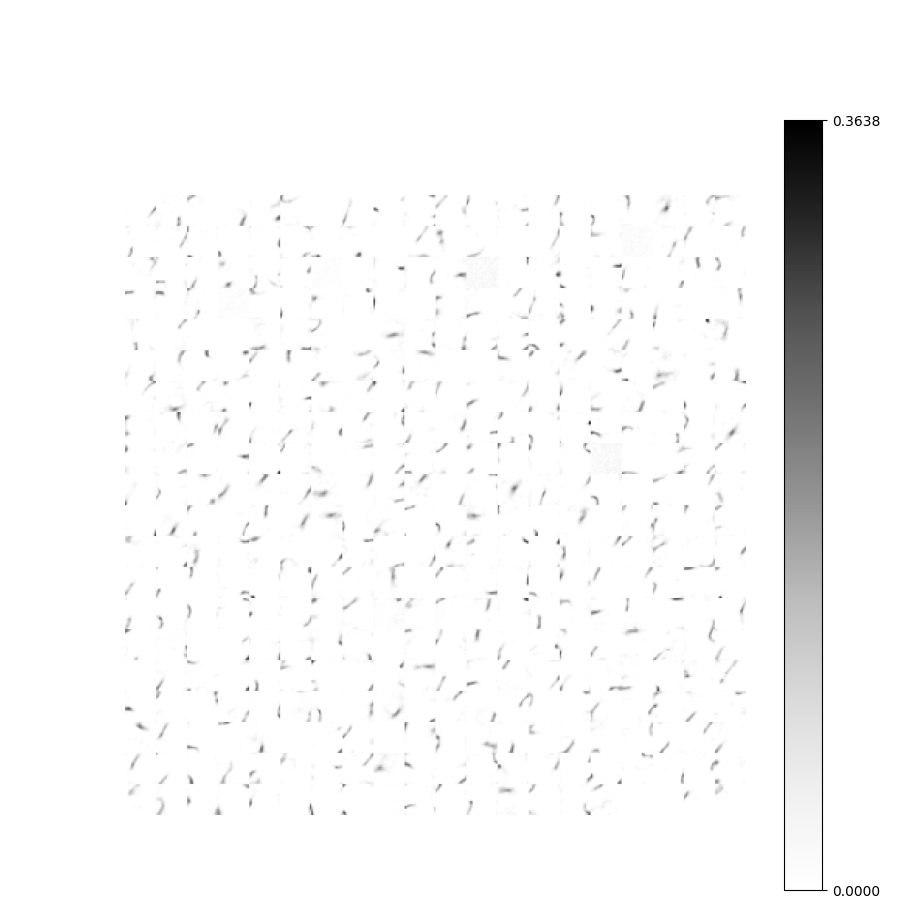

 53%|███████████████████████████████▎                           | 5306/10000 [00:13<00:12, 385.32it/s]

KeyboardInterrupt: 

In [86]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

I interrupted that bad boi because it was taking so long, but *that's* what I'm talking about.  That's super super, ***deeply*** dope.  Let's do some reconstructions.

In [10]:
def reconstruct(img_i, w, Kx, Ky):
    s_len = 20

    img = ts_data[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = np.tanh(mask * p)
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len), cmap="Greys")

    plt.show()

<IPython.core.display.Javascript object>


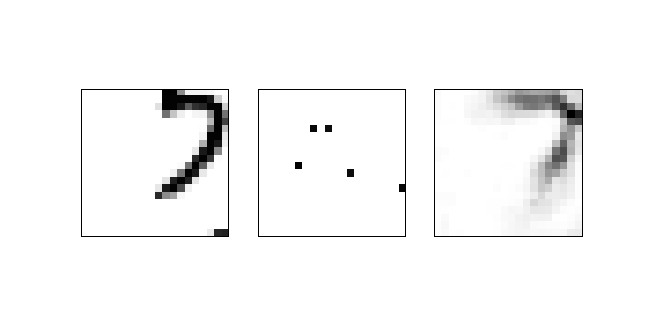

<IPython.core.display.Javascript object>


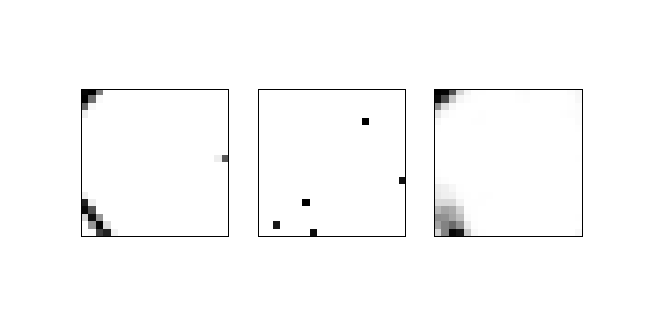

<IPython.core.display.Javascript object>


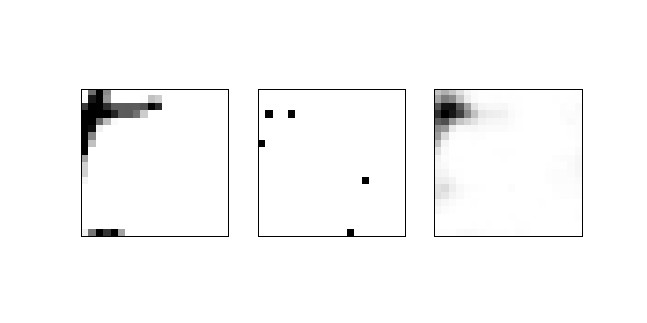

<IPython.core.display.Javascript object>


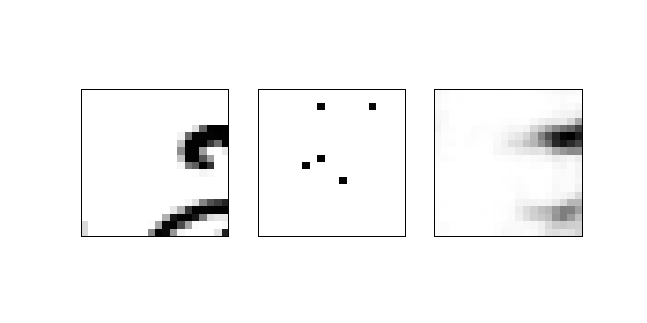

<IPython.core.display.Javascript object>


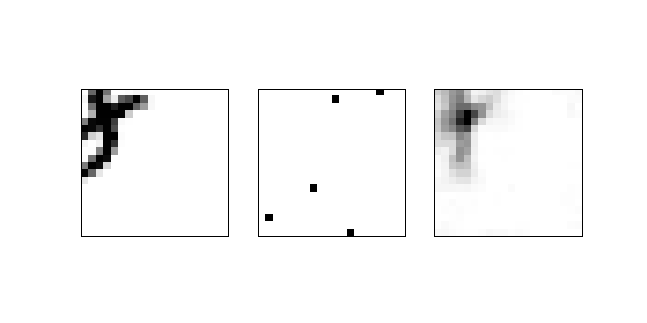

In [92]:
for _ in range(5):
    i = int(np.random.uniform(0, img_count))
    reconstruct(i, w, Kx, Ky)

Ok, not horrible.  Not great, but not horrible.  Obviously better than the 100 neuron network.  You know what?  I'm curious about what would happen with a single winner.

Luckily, I'm the god of this jupyter notebook, so I can find out!

<IPython.core.display.Javascript object>


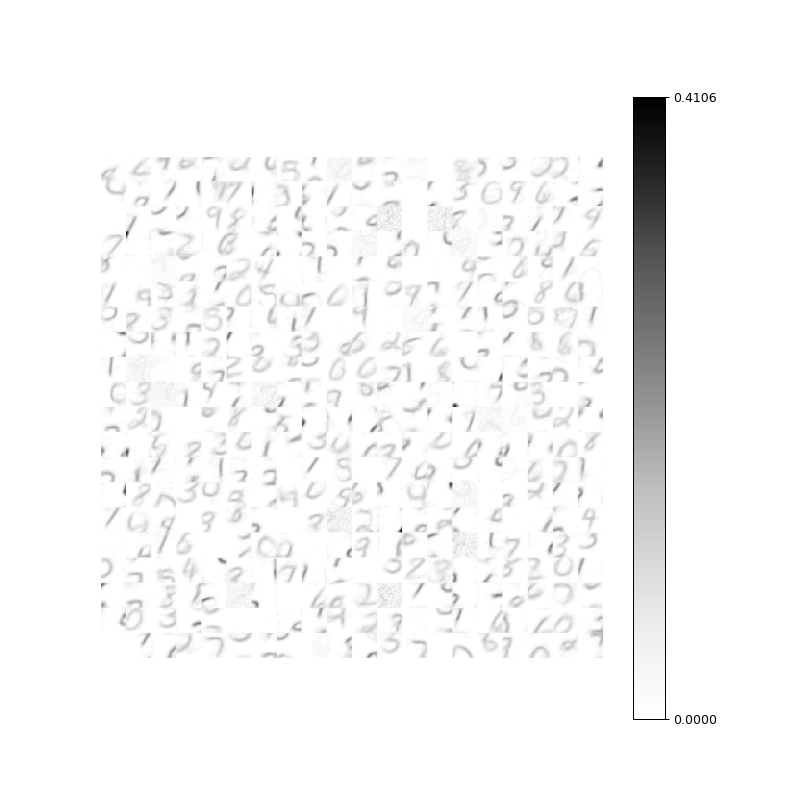

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 1 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    print("Epoch: ", ep)
    for i in range(T_s):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

Well, I guess it basically did what I thought it was going to do.  I'm going to see how three winners looks. 

<IPython.core.display.Javascript object>


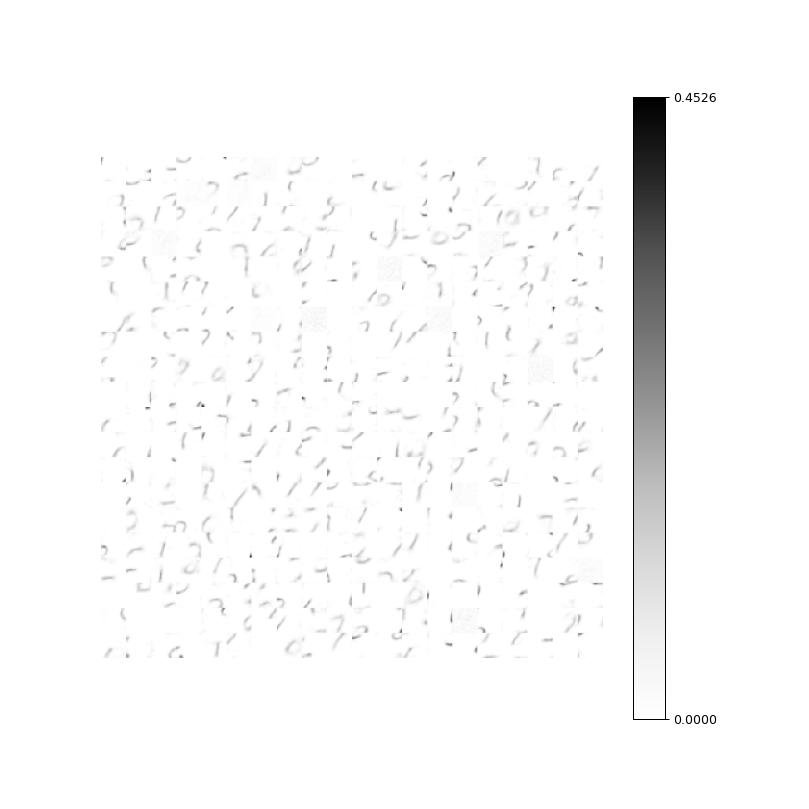

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.30it/s]


In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 3 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
#     print("Epoch: ", ep)
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

I gotta see these reconstructions.

<IPython.core.display.Javascript object>


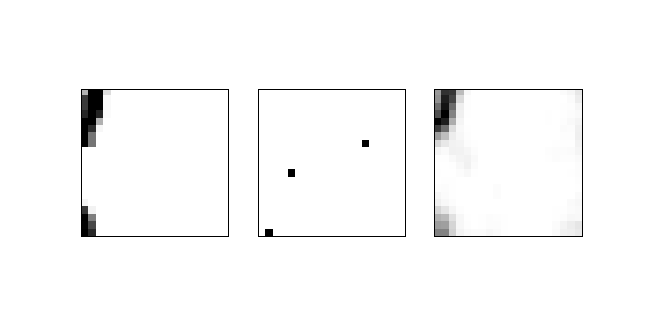

<IPython.core.display.Javascript object>


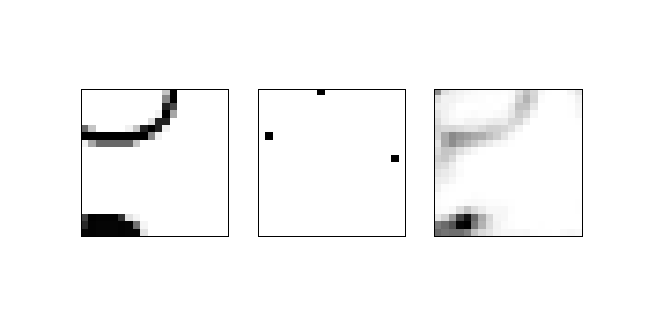

<IPython.core.display.Javascript object>


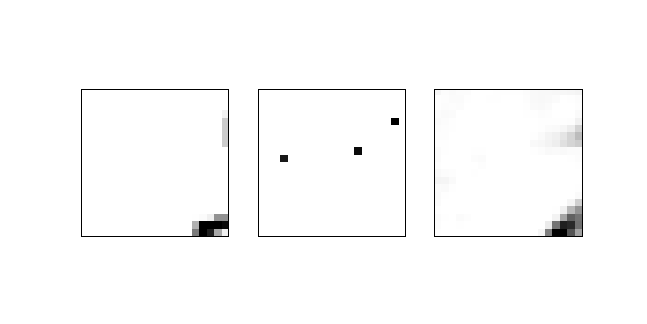

<IPython.core.display.Javascript object>


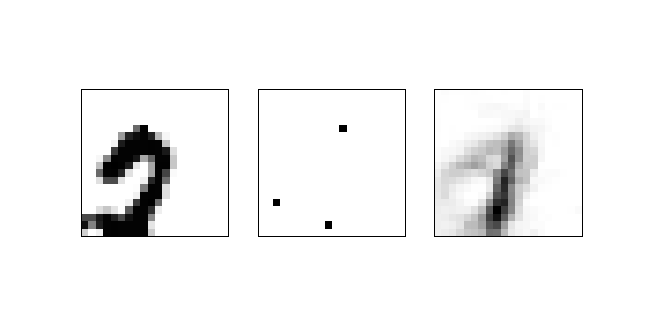

<IPython.core.display.Javascript object>


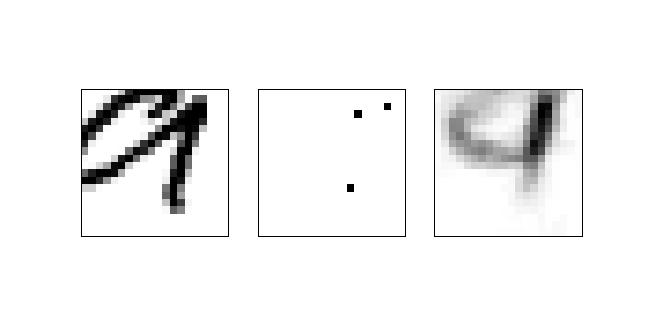

In [13]:
for _ in range(5):
    i = int(np.random.uniform(0, img_count))
    reconstruct(i, w, Kx, Ky)

Wow, that actually seems kinda remarkably good.  I'm going to do some reconstructions in a row, and see how that looks.

<IPython.core.display.Javascript object>


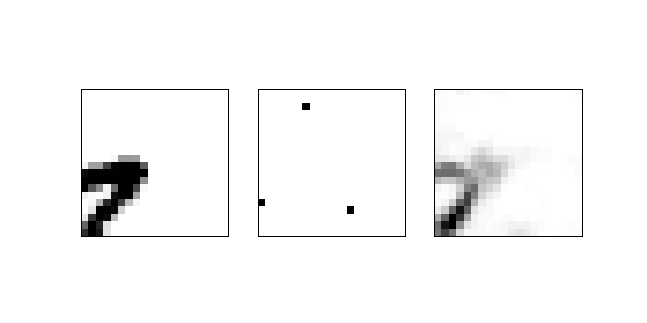

<IPython.core.display.Javascript object>


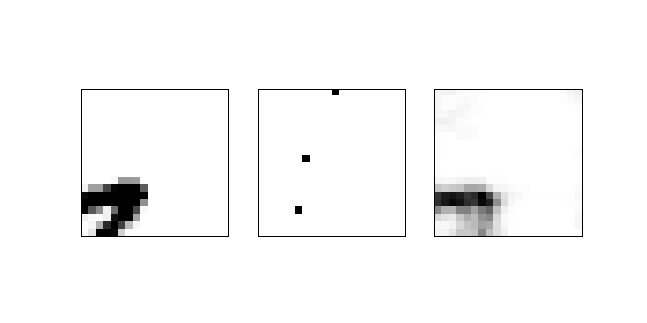

<IPython.core.display.Javascript object>


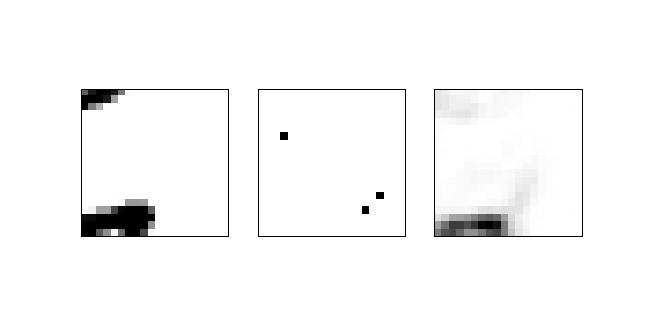

<IPython.core.display.Javascript object>


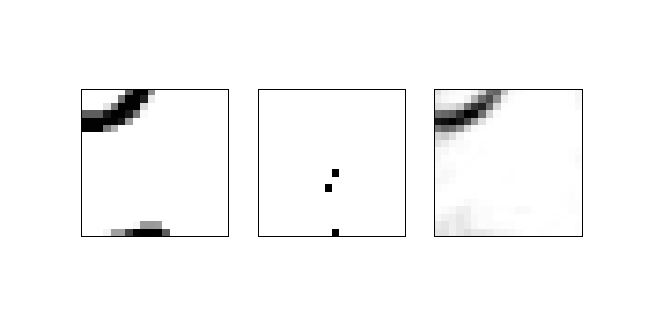

<IPython.core.display.Javascript object>


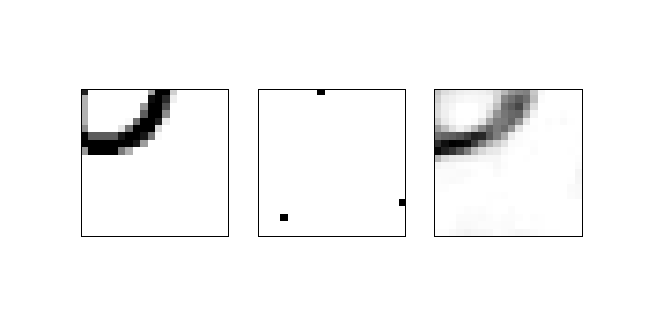

<IPython.core.display.Javascript object>


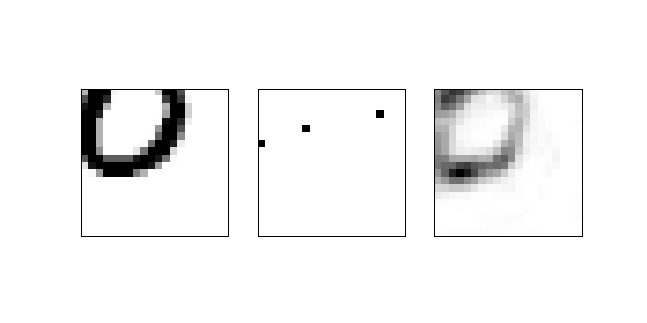

<IPython.core.display.Javascript object>


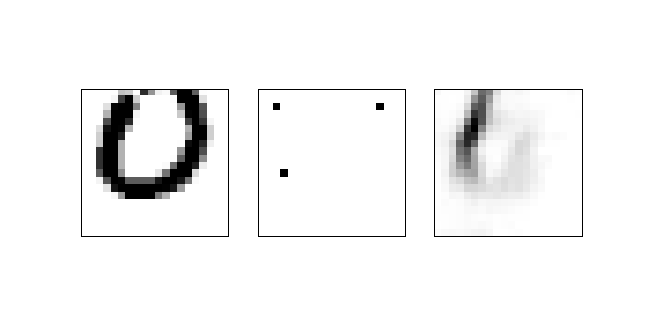

<IPython.core.display.Javascript object>


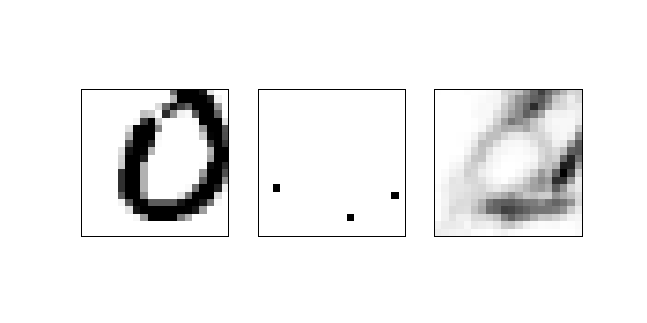

<IPython.core.display.Javascript object>


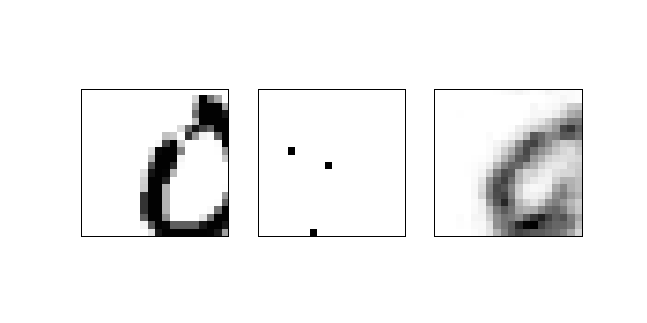

<IPython.core.display.Javascript object>


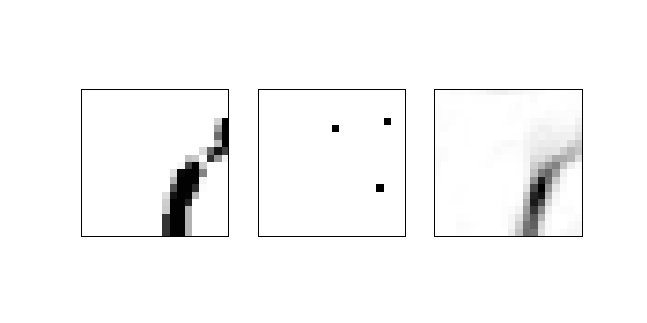

In [15]:
i_start = 100

for i in range(10):
    reconstruct(i + i_start, w, Kx, Ky)

In [16]:
def reconstruct(img_i, w, s_len, Kx, Ky, normalize):
    img = ts_data[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = np.tanh(mask * p)
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    
    if normalize:
        plt.imshow(img.reshape(s_len, s_len), cmap="Greys")
    else:
        plt.imshow(img.reshape(s_len, s_len), cmap="Greys", vmax=1)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    
    if normalize:
        plt.imshow(r.reshape(s_len, s_len), cmap="Greys")
    else:
        plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

    plt.show()

<IPython.core.display.Javascript object>


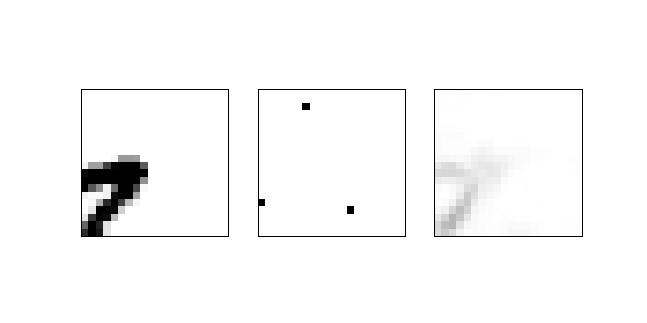

<IPython.core.display.Javascript object>


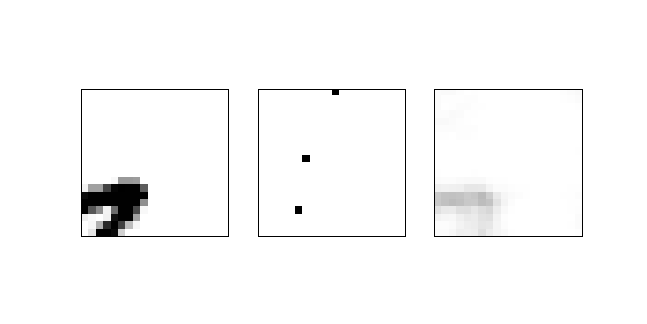

<IPython.core.display.Javascript object>


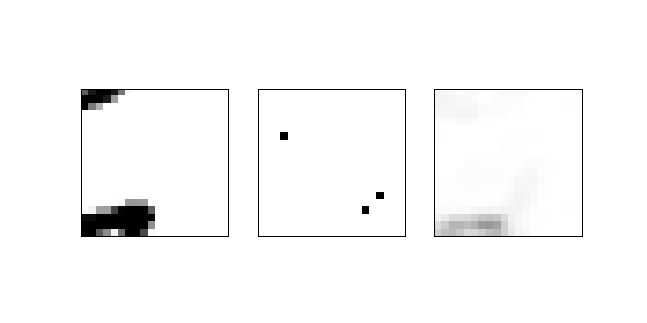

<IPython.core.display.Javascript object>


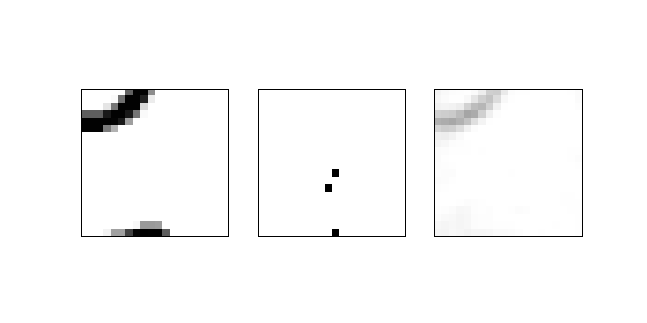

c:\users\daniel geisz\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


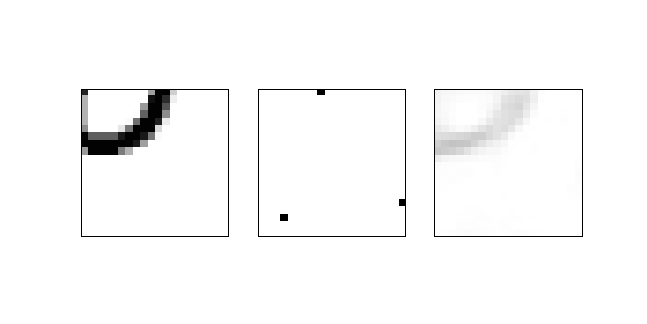

<IPython.core.display.Javascript object>


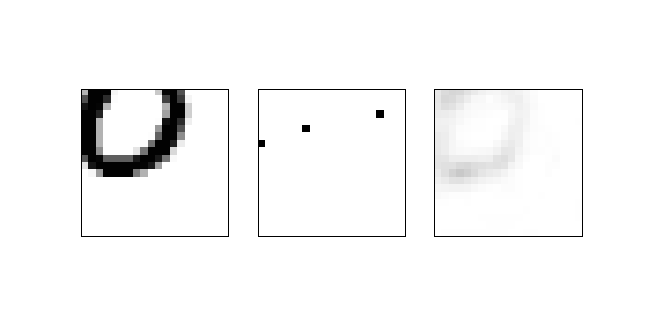

<IPython.core.display.Javascript object>


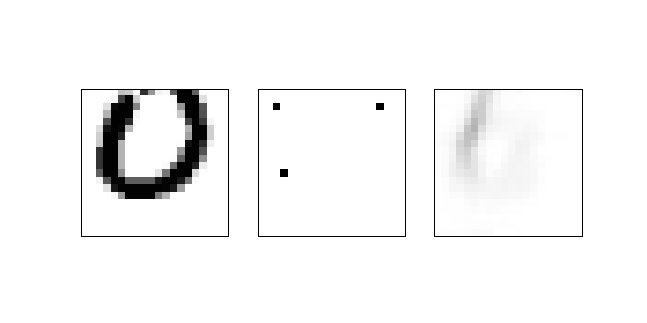

<IPython.core.display.Javascript object>


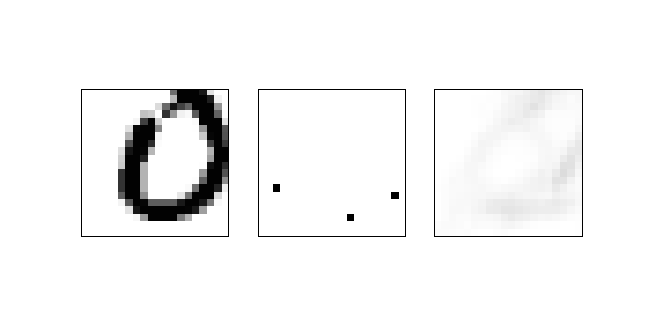

<IPython.core.display.Javascript object>


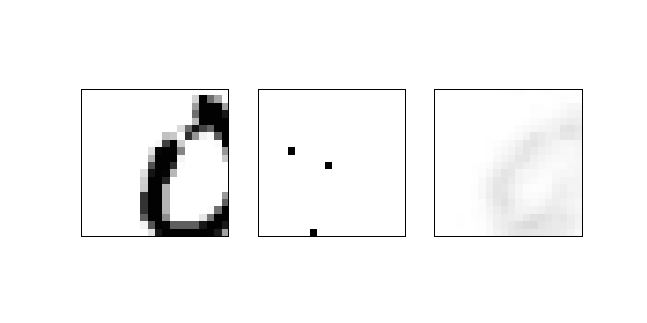

<IPython.core.display.Javascript object>


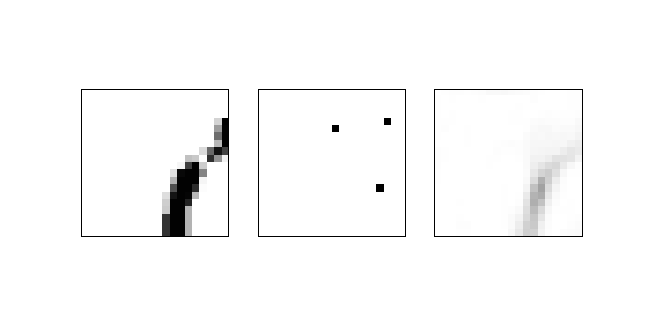

In [18]:
i_start = 100

for i in range(10):
    reconstruct(i + i_start, w, 20, Kx, Ky, False)

Ok, so the normalized images are obviously better than the non-normalized images, but still, that's kinda crazy.

You know what I'd really love to see?  An animation of the original, the sparse coding, and then the normalized reconstruction.

I'm going to make that now.

<IPython.core.display.Javascript object>


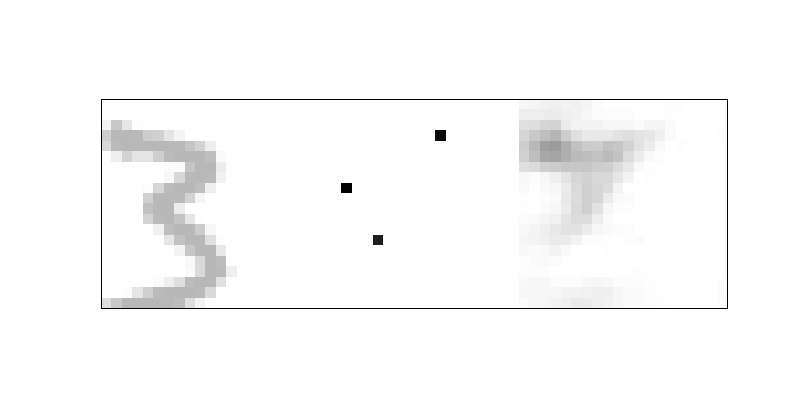

100%|█████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1066.23it/s]


In [26]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Well, that is simply one of the most beautiful things I've ever seen.  As might be expected, it reminds me of the animation from Olshausen's lecture on Yubei's paper.  I haven't implemented anything remotely invariant yet like Yubei's network, but it has the same kind of super cool vibe.  

Ok, I'm going to run 5 winners, and then do the reconstruction animation again.  It's super great that my window dimensions are the same as the hidden layer dimensions.  That makes this animation much easier to make.

K, here we go!

<IPython.core.display.Javascript object>


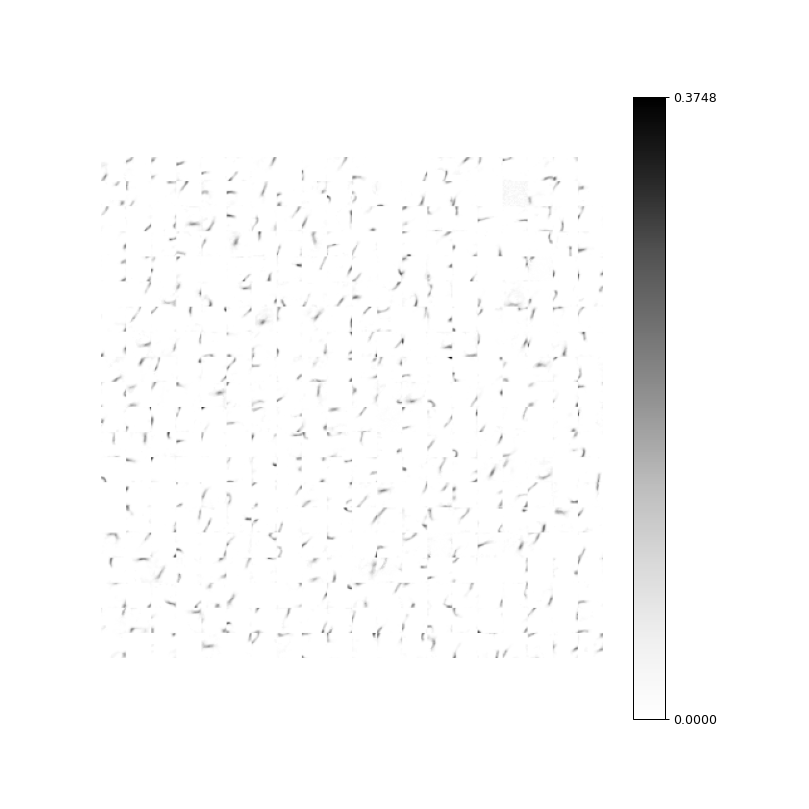

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.05it/s]


In [27]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

Cool. Ok, here's the animation:

In [30]:
w500 = w
n_w500 = n_w

<IPython.core.display.Javascript object>


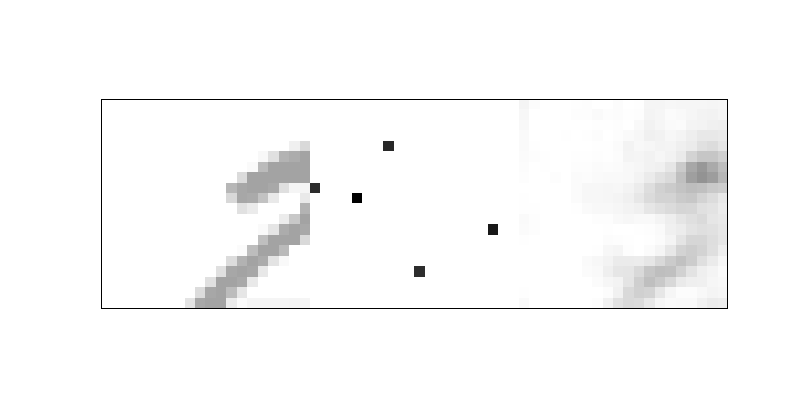

100%|█████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1092.33it/s]


In [31]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w500 @ v
    winners = np.argsort(p, axis=0)[-n_w500:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w500.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Well, that's just incredibly dope.  And, I mean it'll only get better with more neurons.  I don't know if I want to do 900 neurons however.  Maybe that'll have to wait for the FPGA.  

Ok, I'm taking a peak at the prototypes that Yubei's network learns with Olshausen-style sparse coding.  They're definitely ...ah... more crisp.  However, he's doing gradient descent at each step, which is categorically ridiculous.  I'd be nervous about even putting that on an FPGA.  

However, just to see how my prototypes compare, I'm going to plot the prototypes on a black background, so they look more like Yubei's.

<IPython.core.display.Javascript object>


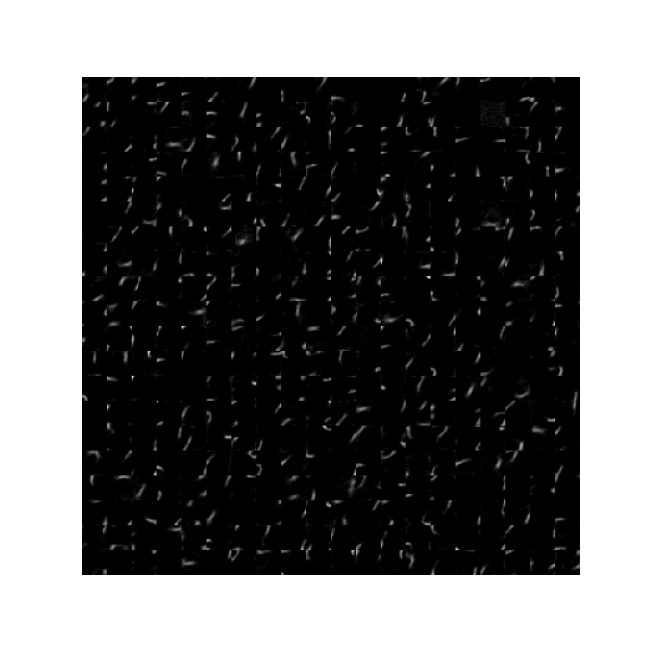

In [35]:
plt.figure(figsize=(8, 8))

s_len = 20
tap_black = np.zeros((s_len * Ky, s_len * Kx))

w_i = 0
for y in range(Ky):
    for x in range(Kx):
        tap_black[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
        w_i += 1

plt.clf()        
max_val = np.max(tap_black)
im = plt.imshow(tap_black, cmap="gray", vmax=max_val)
fig.colorbar(im, ticks=[0, max_val])
plt.axis("off")
fig.canvas.draw()

Given how our prototypes compare, I think he probably wasn't using the "move around a tapestry" approach that I'm doing.  I think he probably just kinda chucked a digit into the middle of the image, and made it dance a bit.  I like my tapestry better. 

Also, it looks like, on average, more of his units were active at a time than mine.  His prototypes are crisp and small.  I'd say maybe 10 on at a time.

Speaking of which, I'm going to do 10 winners as the last run of this experiment.  Well, maybe the last run.  We'll see.

I kinda really want to introduce a tad of topology into this, see what we can't cook up.  I'll have to remember how to prevent domination.

Ok, 10 winners.

<IPython.core.display.Javascript object>


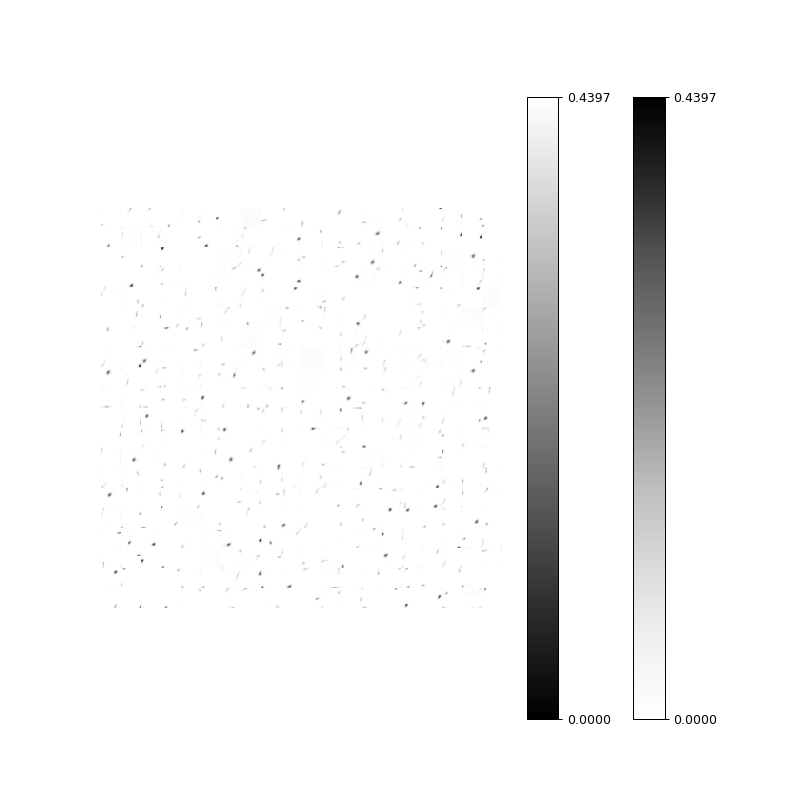

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.65it/s]


In [36]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


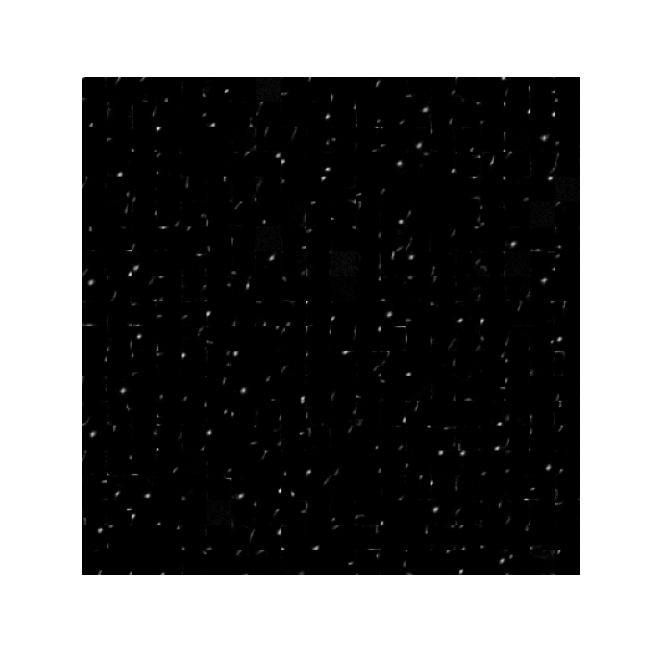

In [37]:
plt.figure(figsize=(8, 8))

s_len = 20
tap_black = np.zeros((s_len * Ky, s_len * Kx))

w_i = 0
for y in range(Ky):
    for x in range(Kx):
        tap_black[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
        w_i += 1

plt.clf()        
max_val = np.max(tap_black)
im = plt.imshow(tap_black, cmap="gray", vmax=max_val)
fig.colorbar(im, ticks=[0, max_val])
plt.axis("off")
fig.canvas.draw()

Wowza. Ok, here's the animation.

<IPython.core.display.Javascript object>


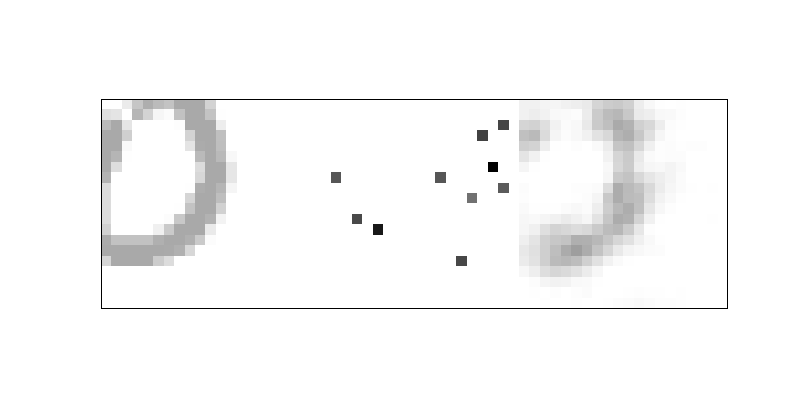

100%|█████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1049.55it/s]


In [38]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, that's actually super super dope.  I know I'm saying that about all the animations, but it's kinda true.  This is really cool.

Now then, I want to see if I can introduce some topology into the sparse layer.  I want neurons firing in a more localized manner.

<IPython.core.display.Javascript object>


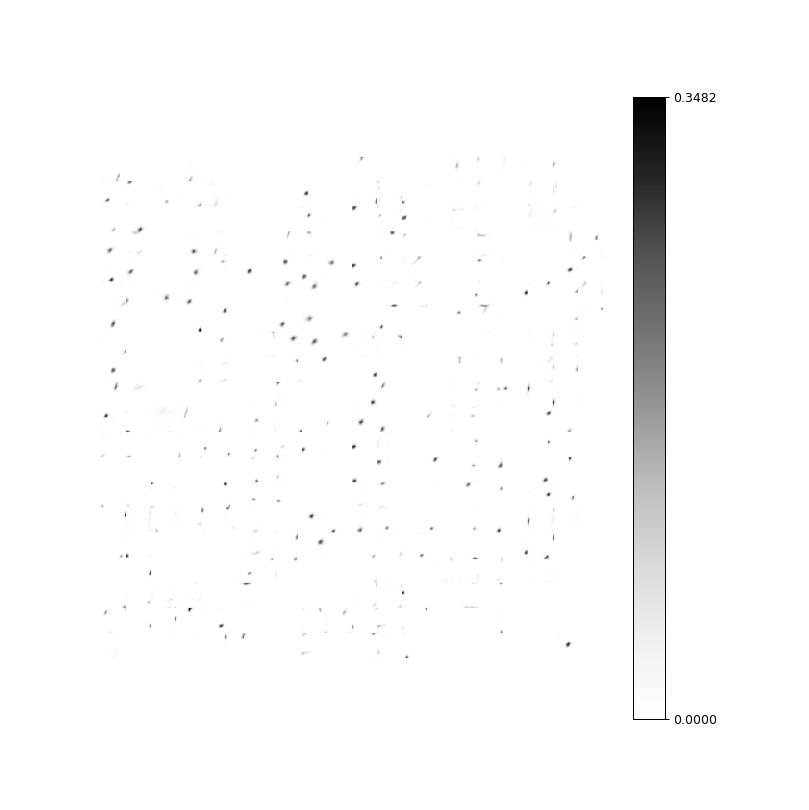

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.77it/s]


In [41]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.02

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

I may be seeing things, but it's honestly looking a bit more organized than before.  The heavy prototypes look like they're  more clustered than before.

Well, there's only way to find out if this is true.  Animations, baby!

<IPython.core.display.Javascript object>


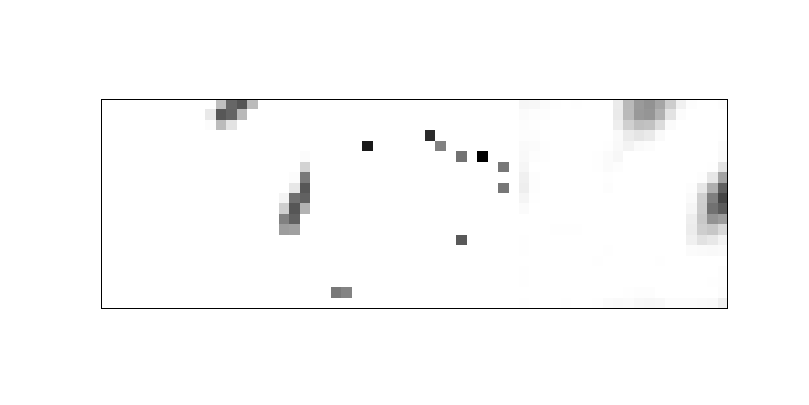

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 826.31it/s]


In [42]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ v
    p += lat_ex @ p
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Hmm.  Again, I think my eyes may be playing tricks, but I think the sparse-coding is more localized.  I think it's at least not crazy random.  I'm going to make the connections as strong as I can (before overflow happens), and see what I can see.

<IPython.core.display.Javascript object>


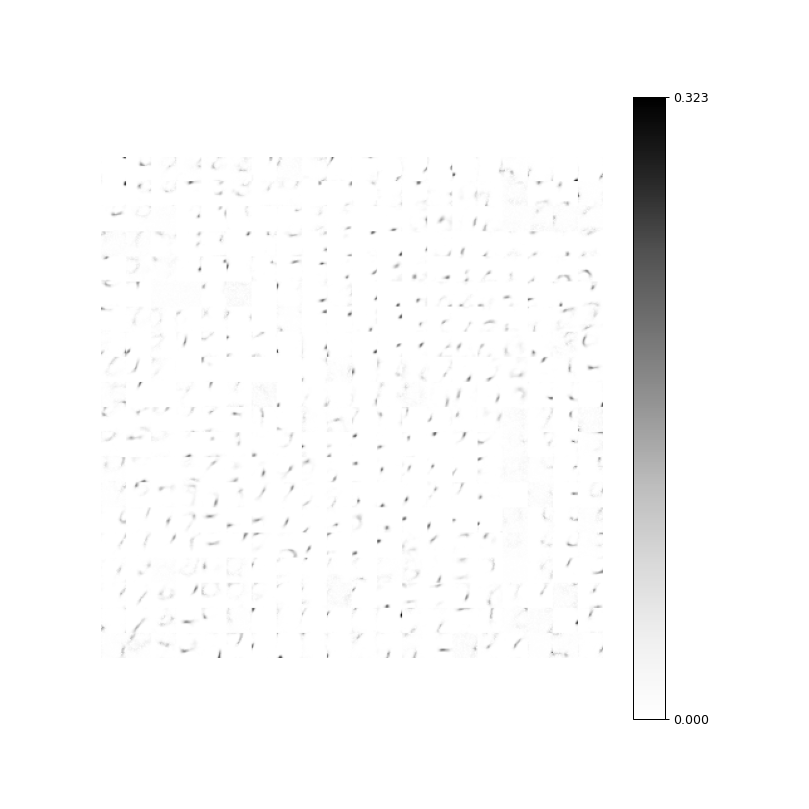

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.74it/s]


In [47]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.005

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


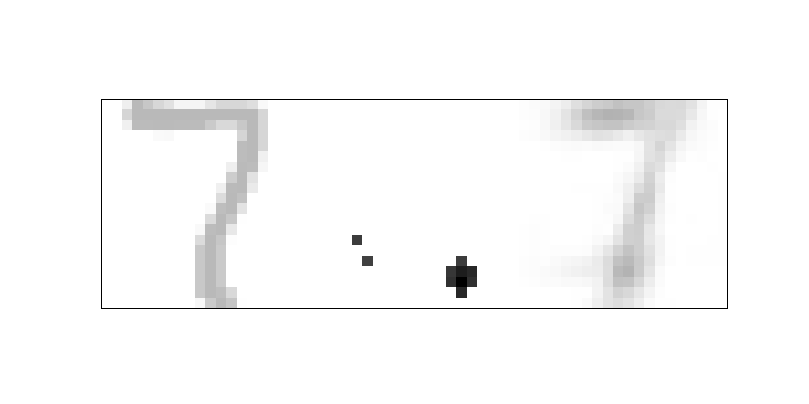

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 823.19it/s]


In [48]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ v
    p += lat_ex @ p
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, I slowed down the learning a bit to really promote topological formation, and there's definitely clustering and localization afoot in the sparse-code.  Which is, of course, deeply dope.  

I mean, look at the coding I randomly stopped at.  That's super clustered.  Also, I tried to raise the lateral excitation above 0.1, but that seemed to be as high as I could get it without overflowing.  Maybe if I enforced a maximum value, I'd get away from the overflow.  Imma try that real quick.

<IPython.core.display.Javascript object>


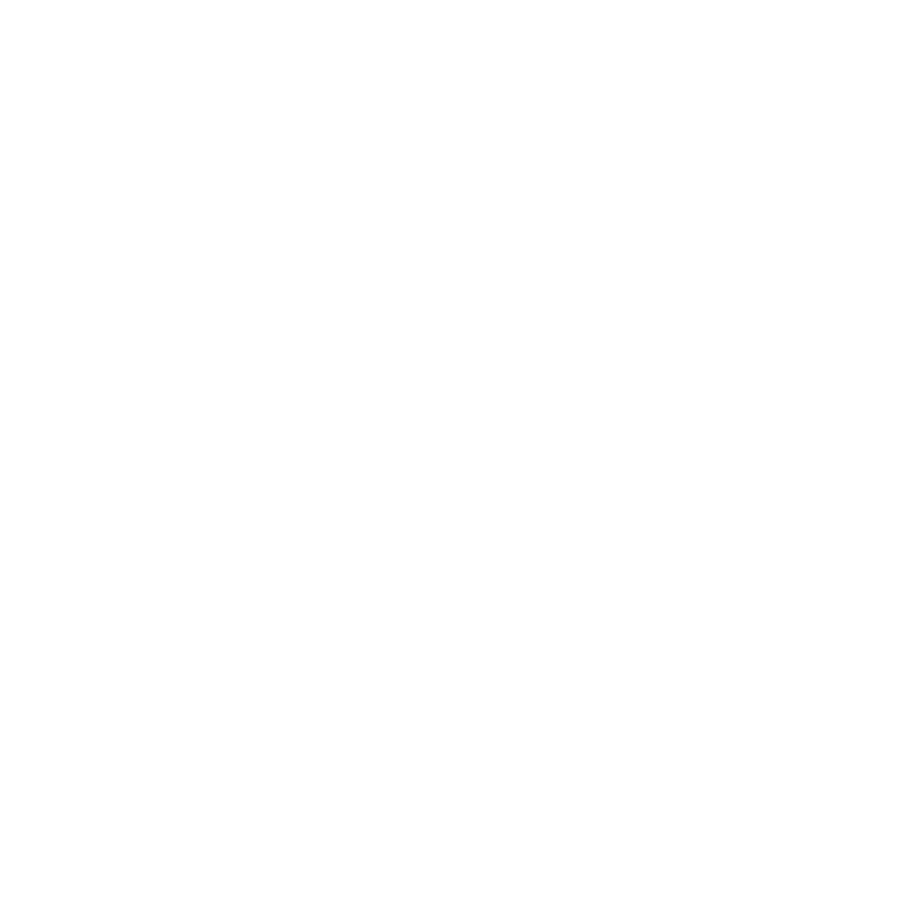

  7%|████▎                                                       | 721/10000 [00:02<00:25, 359.87it/s]


KeyboardInterrupt: 

In [51]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.005

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.3
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        p = np.maximum(p, 1)
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

Nope.  Don't know why that's happening at all.  Ok, I'm going to train this using 5 winners, and then compare it with the weights I saved earlier.

<IPython.core.display.Javascript object>


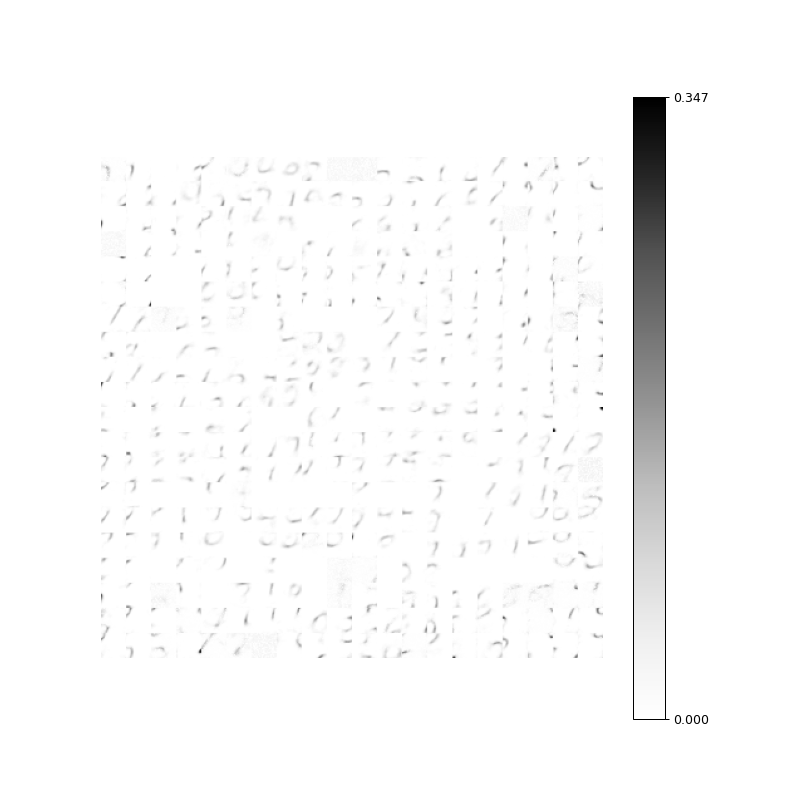

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 356.81it/s]


In [52]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


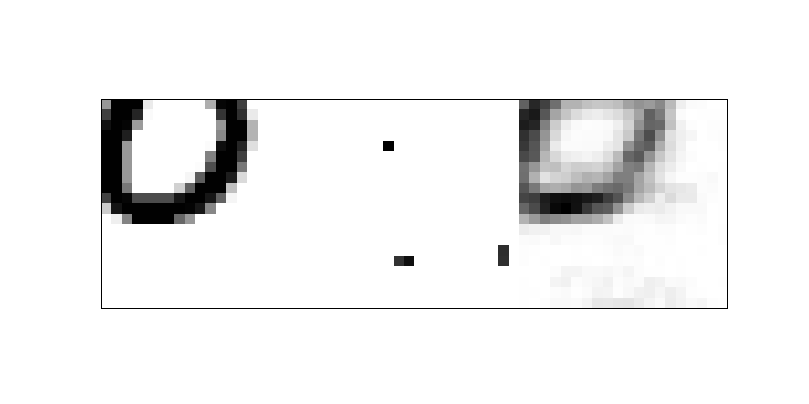

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 764.89it/s]


In [57]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ v
    p += lat_ex @ p
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    o = o / max(prec, np.max(o))
    r = w.T @ o
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Yup, the sparse code is pretty darn localized.  Compare that to:

<IPython.core.display.Javascript object>


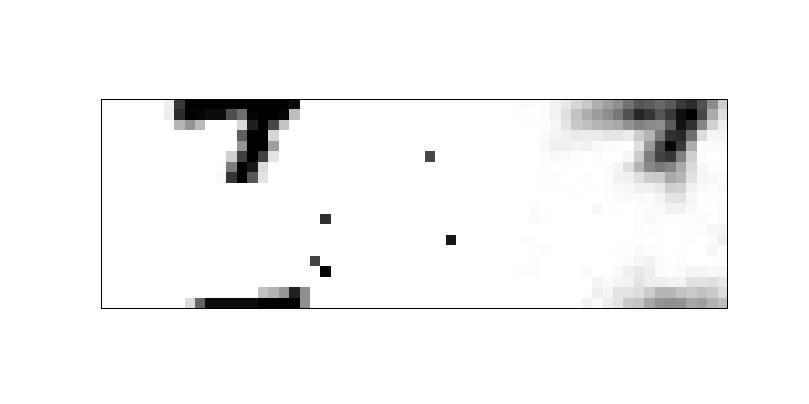



  0%|                                                                         | 0/500 [00:00<?, ?it/s]

 15%|█████████▌                                                     | 76/500 [00:00<00:00, 754.75it/s]

 35%|█████████████████████▋                                        | 175/500 [00:00<00:00, 811.20it/s]

 56%|██████████████████████████████████▌                           | 279/500 [00:00<00:00, 866.96it/s]

 78%|████████████████████████████████████████████████▍             | 391/500 [00:00<00:00, 928.31it/s]

 95%|██████████████████████████████████████████████████████████▉   | 475/500 [00:00<00:00, 708.54it/s]

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 809.33it/s]

In [73]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w500 @ v
    winners = np.argsort(p, axis=0)[-n_w500:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    o = o / max(prec, np.max(o))
    r = w500.T @ o
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Yeah, the second sparse code is absolutely all over the place.  I also normalized the reconstruction and the sparse output just to keep everything as visible as possible.  

Hmm.  This experiment is getting unreasonably long, but there's one more thing I want to try.  Because I am doing time-series data, I can have the output of the neurons be a slower average over the data.  So basically, the sparse layer with be a exponential moving average, rather than directly feed-forward.  Hmm.  Ok, I'm going to try that with 5 neurons, and lateral excitation to promote topology formation.

<IPython.core.display.Javascript object>


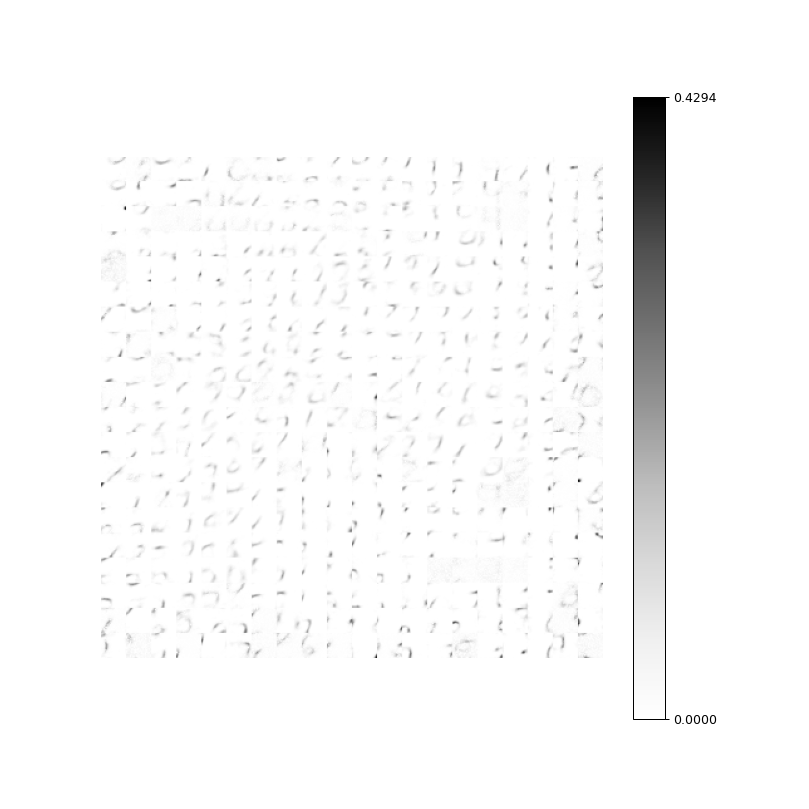

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.02it/s]


In [63]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

nrw = 20 #Number of residual winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = ts_data
    
    o = np.zeros((N, 1))
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        p += lat_ex @ p
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o_c = mask * p
        
        o_r = (o_c + o) / 2
        
        winsr = np.argsort(p, axis=0)[-nrw:]
        maskr = np.zeros((N, 1))
        maskr[winsr] = 1
        
        o = maskr * o_r
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(w, 0)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


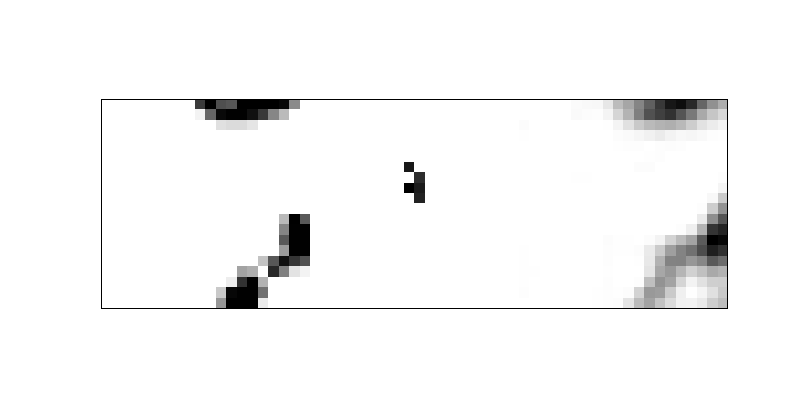

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 777.31it/s]


In [64]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []

o = np.zeros((N, 1))
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ v
    p += lat_ex @ p
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o_c = mask * p

    o_r = (o_c + o) / 2

    winsr = np.argsort(p, axis=0)[-nrw:]
    maskr = np.zeros((N, 1))
    maskr[winsr] = 1

    o = maskr * o_r
    of = o / max(prec, np.max(o))
    r = w.T @ o
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = of.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Eh, I don't think that's really anything.  I thought it might aid in topological formation, but I don't really think it does all that much.  It definitely makes the reconstruction murkier, and that's kinda no good.  

I think I'm going to stick with strict topo sparse coding for now, and maybe I'll incorporate EMA if I think of a another good reason to do so.  

Well, this seems like a pretty darn good place to finish up the ol' experiment.  

Psyche!  The fam just had an incredibly long family meeting, and while what was happening, I got an idea.  

Basically, for lateral excitation, use the output from $t$ as the source of excitation for $t + 1$.  That way, the features are sewn together both spatially and temporaly.  I'm going to try it with 5 winners.

<IPython.core.display.Javascript object>


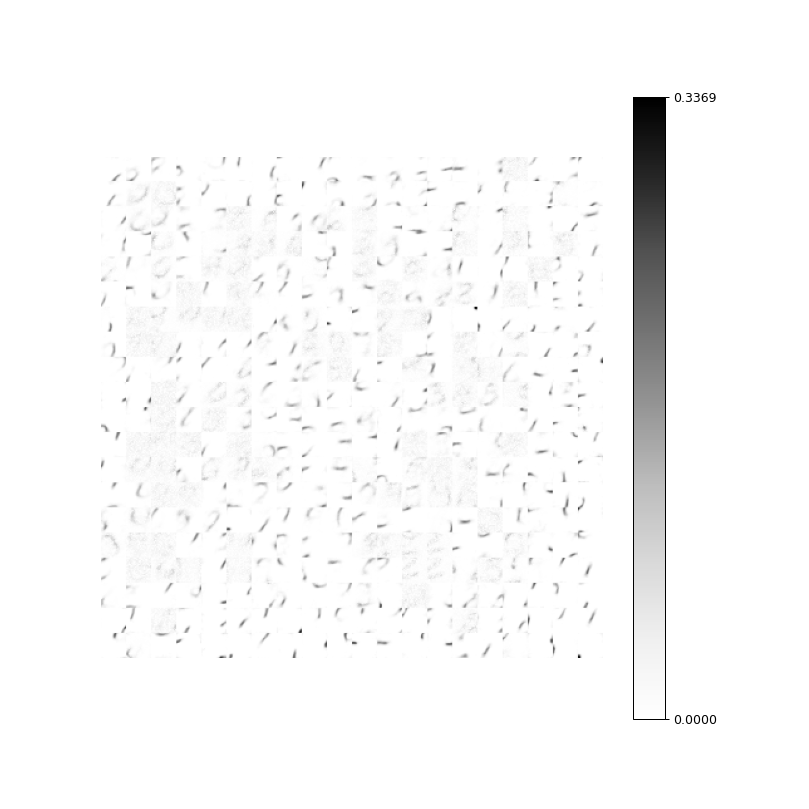

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


In [74]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count
ex = 2

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 0.08
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    print("Epoch: ", ep)
    inputs = ts_data
    o = np.zeros((N, 1))
    for i in range(T_s):
        v = inputs[i].reshape(-1, 1)
        p = (w @ v) + (lat_ex @ o)

        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 100 == 0:
            w = np.clip(w, 0, 1)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


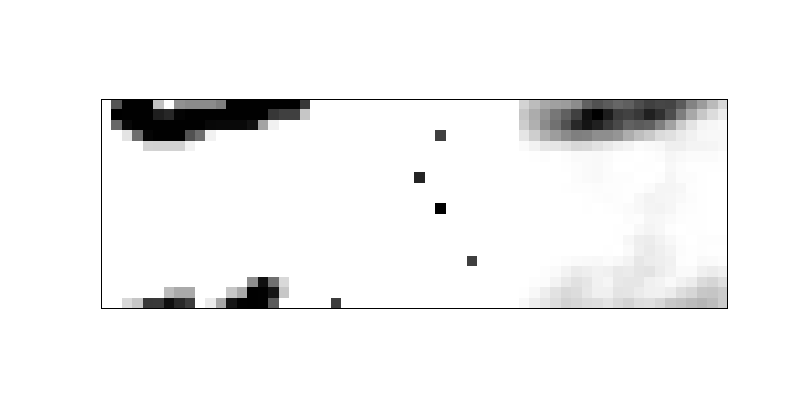



  0%|                                                                         | 0/500 [00:00<?, ?it/s]

 15%|█████████▌                                                     | 76/500 [00:00<00:00, 754.54it/s]

 31%|███████████████████▍                                          | 157/500 [00:00<00:00, 768.76it/s]

 50%|███████████████████████████████                               | 251/500 [00:00<00:00, 812.27it/s]

 69%|███████████████████████████████████████████                   | 347/500 [00:00<00:00, 849.98it/s]

 89%|██████████████████████████████████████████████████████▉       | 443/500 [00:00<00:00, 878.48it/s]

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 870.86it/s]

In [75]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []

o = np.zeros((N, 1))
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = (w @ v) + (lat_ex @ o)

    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    of = o / max(prec, np.max(o))
    r = r / max(prec, np.max(r))
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = of.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Well, that last idea didn't work as well.  Maybe because I didn't give it enough time.  Idk.  Actually, you know what?  The output only had 5 active neurons, so the neurons next to the previous winners probably got sandblasted by the extra boost.  

Hmm.  Ok, so I think probably just use standard lateral excitation to promote the formation of topological feature clustering.  
Ok, now I'm done with this experiment.

## Conclusions

Well, this was a dope experiment.  I super love the animations.  They look cool and they make my brain go boom.  Also, time-series isn't that hard.  Also the tapestry and the tapestry traversal isn't that hard to do.  

Everything is dope, and my life is dope.  

Also, I think it's important to mention that the lateral excitation really does promote topological clustering.  

I was just thinking about having different topological connections, like that one slide Olshausen had about the orientation of dendrites in the cortex.  I think it's just pretty important (like, really, really important) to have those topological connections to keep neurons firing together that typically fire together.  If/when I include an invariant layer, it'll be super important to have those topological connections because the more invariant neurons probably won't be able to do good reconstructions on their own.

Anyway, lots and lots of dope stuff.  

## Next steps

It's time to build the invariant second layer.  There's simply no excuse.  

Also, you know what?  I think weighted averages actually might be the way to go.  They really bit my butt back in November, but that would ensure that each neuron would fire an amount proportional to the filtered input.  That actually might be a really good. Idea.  

All the training would be done in terms of ability to reconstruct, which would also normalize the weights.  Be that as it may, I think at the end of the day, I might just see a couple neurons winning.

You know what?  This is a short lil experiment, I don't think it deserves it's own writeup.  I'm going to try to make it work here, and if it doesn't, then ok, time to move on.  

<IPython.core.display.Javascript object>


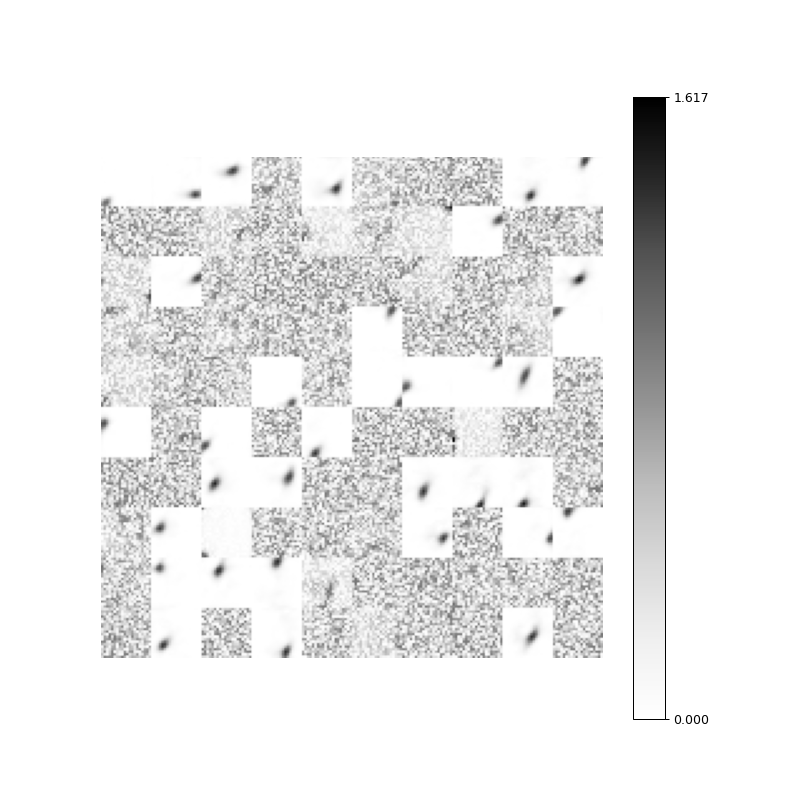

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


In [78]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    print("Epoch: ", ep)
    for i in range(T_s):
        v = inputs[i].reshape(-1, 1)
        p = (w @ v) / np.maximum(prec, np.sum(w, axis=1).reshape(-1, 1))
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

## Next steps - cont.

Ok, yeah.  Only a couple neurons win.  We obviously need as many neurons to win as possible, so I think this is right out.  I'm going to see what happens if we introduce lateral connections, however.

Actually, no I'm not.  I just really need only a couple neurons winning at a time.  There are ways to get around this, however.  I'm still thinking about adding a normalizing constant that adjusts to be sure the input matches the output.  So basically, a learned normalizing constant.  

Or, I mean, I could just chuck it through a non-linearity.  That's always an option.  I'm going to quickly run the above network being passed through tanh.

<IPython.core.display.Javascript object>


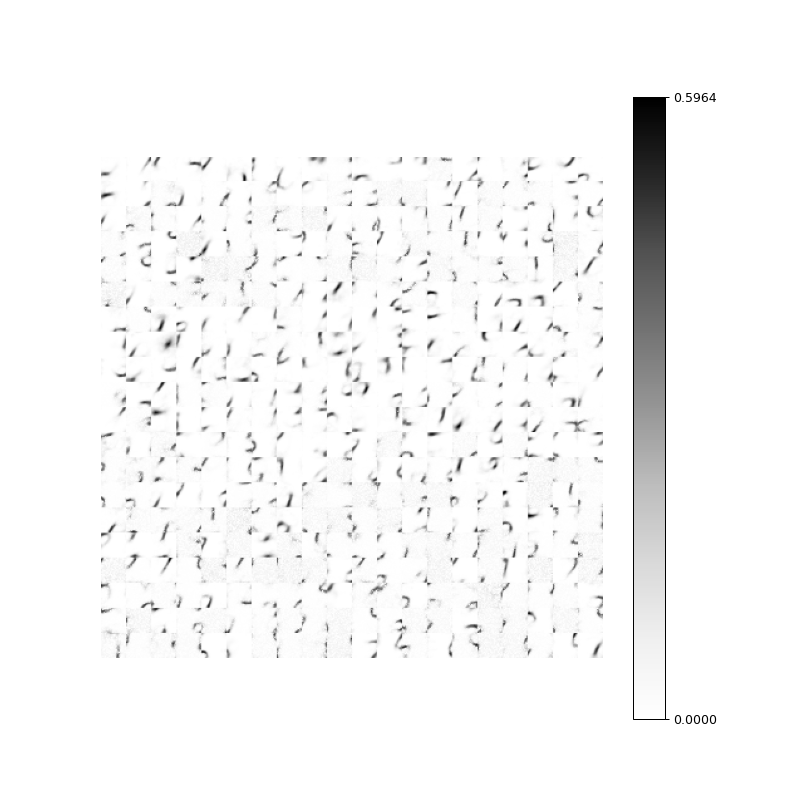

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


In [86]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 3 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.01

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    print("Epoch: ", ep)
    for i in range(T_s):
        v = inputs[i].reshape(-1, 1)
        p = np.tanh(w @ v)
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


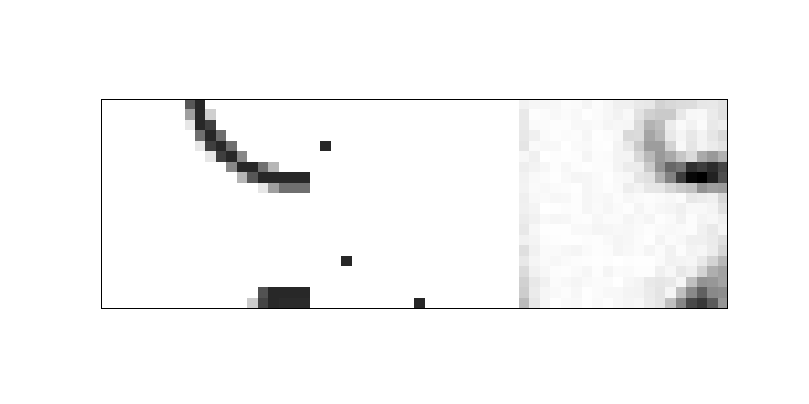



  0%|                                                                         | 0/500 [00:00<?, ?it/s]

 14%|█████████                                                      | 72/500 [00:00<00:00, 718.61it/s]

 36%|██████████████████████▍                                       | 181/500 [00:00<00:00, 798.56it/s]

 59%|████████████████████████████████████▋                         | 296/500 [00:00<00:00, 877.69it/s]

 81%|██████████████████████████████████████████████████            | 404/500 [00:00<00:00, 928.85it/s]

100%|█████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1009.66it/s]

In [87]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = np.tanh(w @ v)
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

The non-linearity makes it...weird.  I, however, should have retired this experiment a while ago, so I'll do that now.

Basically, implement the invariance, and figure out how to normalize the weights without literally everything going psycho.